필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

In [3]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.preprocessing import StandardScaler

데이터 가져오기

In [5]:
base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/"
# base_path = r"C:\Users\owner\Desktop\water-source\data"

In [6]:
jsb_yearly = pd.read_excel(base_path+"Jugsanbo.xlsx", 
# jsb_yearly = pd.read_excel(base_path+"\Jugsanbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [7]:
print(type(jsb_yearly))  # type-dict
print(jsb_yearly.keys())  # 2012년부터 2022년까지

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])


In [8]:
jsb_yearly['2012년'].columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L', '탁도 NTU',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

2013년 자료부터

In [9]:
jsb_yearly_df13 = pd.DataFrame()

for item in list(jsb_yearly.keys())[1:]:
    jsb_yearly_df13 = pd.concat([jsb_yearly_df13, jsb_yearly[item]])

In [10]:
jsb_yearly_df13 = jsb_yearly_df13.reset_index(drop=True)

결측치 확인

In [11]:
jsb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82064 entries, 0 to 82063
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
dtypes: float64(9), object(2)
memory usage: 6.9+ MB


In [12]:
jsb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
수소이온농도          9972
전기전도도 μS/cm     9925
용존산소 mg/L      11066
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
dtype: int64

In [13]:
jsb_yearly_df13.head()

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,탁도 NTU,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00h,나주,3.3,6.8,272.0,12.0,1.8,1.9,NaN,NaN,12.2
1,2013-01-01 01h,나주,3.1,6.7,272.0,12.0,1.7,1.9,NaN,NaN,12.0
2,2013-01-01 02h,나주,3.0,6.7,273.0,12.0,1.7,1.9,NaN,NaN,12.1
3,2013-01-01 03h,나주,3.0,6.7,275.0,12.0,1.6,1.9,NaN,NaN,12.2
4,2013-01-01 04h,나주,2.9,6.7,276.0,12.0,1.5,1.9,NaN,NaN,12.1


유량 데이터 추가하기

In [14]:
jsb_flow_yearly = pd.read_excel(base_path+"Jugsanbo_flow.xlsx", 
# jsb_flow_yearly = pd.read_excel(base_path+"\Jugsanbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [15]:
for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly[year]['연월일시'] = jsb_flow_yearly[year]['시간'].apply(lambda x : x[:-3])

In [16]:
jsb_flow_yearly_hour = {}

for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly[year].groupby('연월일시').mean()

In [17]:
for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly_hour[year].reset_index()

In [18]:
jsb_flow_yearly_hour_df = pd.DataFrame()

for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour_df = pd.concat([jsb_flow_yearly_hour_df, jsb_flow_yearly_hour[year]])

In [19]:
jsb_flow_yearly_hour_df = jsb_flow_yearly_hour_df.reset_index(drop=True)

In [20]:
print(jsb_flow_yearly_hour_df.__len__())
print(jsb_yearly_df13.__len__())

84462
82064


In [21]:
jsb_yearly_df13['연월일시'] = jsb_yearly_df13['측정일/월'].transform(lambda x: x.strip('h').replace('-', '.'))

In [22]:
jsb_data = pd.merge(jsb_yearly_df13, jsb_flow_yearly_hour_df, how='outer')

In [23]:
jsb_data = jsb_data[:82064]

In [24]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12   상류수위(EL.m)  82051 non-null  float64
 13   하류수위(EL.m)  82051 non-null  float64
 14   유입량(㎥/s)    82051 non-null  float64
 15   방류량(㎥/s)    82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [25]:
jsb_data.columns = [x.strip() for x in list(jsb_data.columns)]

In [26]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12  상류수위(EL.m)   82051 non-null  float64
 13  하류수위(EL.m)   82051 non-null  float64
 14  유입량(㎥/s)     82051 non-null  float64
 15  방류량(㎥/s)     82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [27]:
list(jsb_data.columns)[:-5] + list(jsb_data.columns)[-4:-3] + list(jsb_data.columns)[-1:]

['측정일/월',
 '측정소명',
 '수온 ℃',
 '수소이온농도',
 '전기전도도 μS/cm',
 '용존산소 mg/L',
 '탁도 NTU',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '클로로필-a mg/㎥',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [28]:
jsb_data = jsb_data.loc[:, list(jsb_data.columns)[:3]  + list(jsb_data.columns)[4:5] + list(jsb_data.columns)[6:-5] + list(jsb_data.columns)[-4:-3] + list(jsb_data.columns)[-1:]]

In [29]:
jsb_data.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [30]:
jsb_data.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
전기전도도 μS/cm     9925
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
상류수위(EL.m)        13
방류량(㎥/s)          13
dtype: int64

In [31]:
jsb_data.isnull().sum() /len(jsb_data)

측정일/월          0.000000
측정소명           0.000000
수온 ℃           0.123184
전기전도도 μS/cm    0.120942
탁도 NTU         0.131020
총유기탄소 mg/L     0.195128
총질소 mg/L       0.182053
총인 mg/L        0.174157
클로로필-a mg/㎥    0.151357
상류수위(EL.m)     0.000158
방류량(㎥/s)       0.000158
dtype: float64

In [32]:
len(jsb_data)

82064

시간데이터 추가

In [33]:
jsb_df = jsb_data.copy()

In [34]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [35]:
col_c = list(jsb_df.columns.copy())
col_c.remove('클로로필-a mg/㎥')

In [36]:
col_c

['측정일/월',
 '측정소명',
 '수온 ℃',
 '전기전도도 μS/cm',
 '탁도 NTU',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [37]:
for var in col_c[2:]:
    for i in range(1, 73):
        jsb_df[str(i) + 'shift' + var] = jsb_df[var].shift(i)

/tmp/ipykernel_658/3671321184.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  jsb_df[str(i) + 'shift' + var] = jsb_df[var].shift(i)


In [38]:
len(jsb_df)

82064

In [39]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)',
       ...
       '63shift방류량(㎥/s)', '64shift방류량(㎥/s)', '65shift방류량(㎥/s)',
       '66shift방류량(㎥/s)', '67shift방류량(㎥/s)', '68shift방류량(㎥/s)',
       '69shift방류량(㎥/s)', '70shift방류량(㎥/s)', '71shift방류량(㎥/s)',
       '72shift방류량(㎥/s)'],
      dtype='object', length=587)

In [40]:
len(jsb_df)

82064

결측치 보간법

In [41]:
from datetime import datetime

In [42]:
jsb_df = jsb_df.copy()

In [43]:
jsb_df['측정일/월'] = jsb_df['측정일/월'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

In [44]:
jsb_df = jsb_df.copy().set_index('측정일/월').interpolate(method='time')

In [45]:
jsb_df = jsb_df.dropna()

In [46]:
jsb_df.__len__()

79891

In [47]:
jsb_df.columns

Index(['측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)',
       ...
       '63shift방류량(㎥/s)', '64shift방류량(㎥/s)', '65shift방류량(㎥/s)',
       '66shift방류량(㎥/s)', '67shift방류량(㎥/s)', '68shift방류량(㎥/s)',
       '69shift방류량(㎥/s)', '70shift방류량(㎥/s)', '71shift방류량(㎥/s)',
       '72shift방류량(㎥/s)'],
      dtype='object', length=586)

In [48]:
col = list(jsb_df.columns[2:])
print(col)

['전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift수온 ℃', '2shift수온 ℃', '3shift수온 ℃', '4shift수온 ℃', '5shift수온 ℃', '6shift수온 ℃', '7shift수온 ℃', '8shift수온 ℃', '9shift수온 ℃', '10shift수온 ℃', '11shift수온 ℃', '12shift수온 ℃', '13shift수온 ℃', '14shift수온 ℃', '15shift수온 ℃', '16shift수온 ℃', '17shift수온 ℃', '18shift수온 ℃', '19shift수온 ℃', '20shift수온 ℃', '21shift수온 ℃', '22shift수온 ℃', '23shift수온 ℃', '24shift수온 ℃', '25shift수온 ℃', '26shift수온 ℃', '27shift수온 ℃', '28shift수온 ℃', '29shift수온 ℃', '30shift수온 ℃', '31shift수온 ℃', '32shift수온 ℃', '33shift수온 ℃', '34shift수온 ℃', '35shift수온 ℃', '36shift수온 ℃', '37shift수온 ℃', '38shift수온 ℃', '39shift수온 ℃', '40shift수온 ℃', '41shift수온 ℃', '42shift수온 ℃', '43shift수온 ℃', '44shift수온 ℃', '45shift수온 ℃', '46shift수온 ℃', '47shift수온 ℃', '48shift수온 ℃', '49shift수온 ℃', '50shift수온 ℃', '51shift수온 ℃', '52shift수온 ℃', '53shift수온 ℃', '54shift수온 ℃', '55shift수온 ℃', '56shift수온 ℃', '57shift수온 ℃', '58shift수온 ℃', '59shift수온 ℃', '60shift수온 ℃', '61sh

In [49]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
print(col_v)

['전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)', '1shift수온 ℃', '2shift수온 ℃', '3shift수온 ℃', '4shift수온 ℃', '5shift수온 ℃', '6shift수온 ℃', '7shift수온 ℃', '8shift수온 ℃', '9shift수온 ℃', '10shift수온 ℃', '11shift수온 ℃', '12shift수온 ℃', '13shift수온 ℃', '14shift수온 ℃', '15shift수온 ℃', '16shift수온 ℃', '17shift수온 ℃', '18shift수온 ℃', '19shift수온 ℃', '20shift수온 ℃', '21shift수온 ℃', '22shift수온 ℃', '23shift수온 ℃', '24shift수온 ℃', '25shift수온 ℃', '26shift수온 ℃', '27shift수온 ℃', '28shift수온 ℃', '29shift수온 ℃', '30shift수온 ℃', '31shift수온 ℃', '32shift수온 ℃', '33shift수온 ℃', '34shift수온 ℃', '35shift수온 ℃', '36shift수온 ℃', '37shift수온 ℃', '38shift수온 ℃', '39shift수온 ℃', '40shift수온 ℃', '41shift수온 ℃', '42shift수온 ℃', '43shift수온 ℃', '44shift수온 ℃', '45shift수온 ℃', '46shift수온 ℃', '47shift수온 ℃', '48shift수온 ℃', '49shift수온 ℃', '50shift수온 ℃', '51shift수온 ℃', '52shift수온 ℃', '53shift수온 ℃', '54shift수온 ℃', '55shift수온 ℃', '56shift수온 ℃', '57shift수온 ℃', '58shift수온 ℃', '59shift수온 ℃', '60shift수온 ℃', '61shift수온 ℃', '62sh

피처 정규화 없이

In [50]:
X_train, X_test, y_train, y_test = train_test_split(jsb_df.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [51]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3, verbose=5)

In [52]:
gb_grid.fit(X_train, np.log1p(y_train))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.749 total time=13.5min
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.748 total time=13.3min
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.752 total time=13.4min
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.952 total time=26.1min
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.951 total time=26.4min
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.947 total time=26.4min
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.964 total time=37.3min
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.967 total time=37.3min
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.963 total time=37.2min
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.821 total time=13.4min
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.815 total time=13.3min
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [53]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [54]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.965022,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.964617,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.960585,3
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.960352,4
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.959957,5


In [55]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [56]:
estimator = gb_grid.best_estimator_

In [57]:
pred = estimator.predict(X_test)

In [58]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.01 전기전도도 μS/cm
0.1 탁도 NTU
0.1 총유기탄소 mg/L
0.01 총질소 mg/L
0.02 총인 mg/L
0.01 상류수위(EL.m)
0.0 방류량(㎥/s)
0.02 1shift수온 ℃
0.0 2shift수온 ℃
0.0 3shift수온 ℃
0.0 4shift수온 ℃
0.0 5shift수온 ℃
0.0 6shift수온 ℃
0.0 7shift수온 ℃
0.0 8shift수온 ℃
0.0 9shift수온 ℃
0.0 10shift수온 ℃
0.0 11shift수온 ℃
0.0 12shift수온 ℃
0.0 13shift수온 ℃
0.0 14shift수온 ℃
0.0 15shift수온 ℃
0.0 16shift수온 ℃
0.0 17shift수온 ℃
0.0 18shift수온 ℃
0.0 19shift수온 ℃
0.0 20shift수온 ℃
0.0 21shift수온 ℃
0.0 22shift수온 ℃
0.0 23shift수온 ℃
0.0 24shift수온 ℃
0.0 25shift수온 ℃
0.0 26shift수온 ℃
0.0 27shift수온 ℃
0.0 28shift수온 ℃
0.0 29shift수온 ℃
0.0 30shift수온 ℃
0.0 31shift수온 ℃
0.01 32shift수온 ℃
0.0 33shift수온 ℃
0.0 34shift수온 ℃
0.0 35shift수온 ℃
0.0 36shift수온 ℃
0.0 37shift수온 ℃
0.0 38shift수온 ℃
0.0 39shift수온 ℃
0.0 40shift수온 ℃
0.0 41shift수온 ℃
0.0 42shift수온 ℃
0.05 43shift수온 ℃
0.0 44shift수온 ℃
0.0 45shift수온 ℃
0.0 46shift수온 ℃
0.0 47shift수온 ℃
0.0 48shift수온 ℃
0.0 49shift수온 ℃
0.0 50shift수온 ℃
0.0 51shift수온 ℃
0.0 52shift수온 ℃
0.0 53shift수온 ℃
0.0 54shift수온 ℃
0.0 55shift수온 ℃
0.0 56shift수온 ℃
0.0 57shift

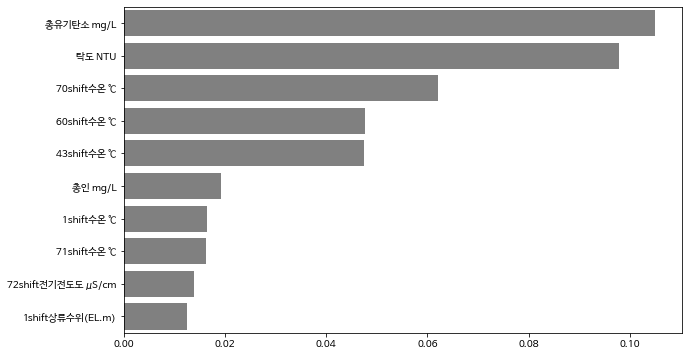

In [59]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [60]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.978292588056208


In [61]:
feature_series[:10]

총유기탄소 mg/L            0.104963
탁도 NTU                0.097905
70shift수온 ℃           0.062031
60shift수온 ℃           0.047629
43shift수온 ℃           0.047465
총인 mg/L               0.019206
1shift수온 ℃            0.016440
71shift수온 ℃           0.016337
72shift전기전도도 μS/cm    0.013885
1shift상류수위(EL.m)      0.012490
dtype: float64

피처 정규화

In [62]:
scaler = StandardScaler()
scaler.fit(jsb_df.loc[:, col_v])
jsb_scaled = scaler.transform(jsb_df.loc[:, col_v])

jsb_df_scaled = pd.DataFrame(data = jsb_scaled, columns = col_v)

In [63]:
jsb_df_scaled.head()

,전기전도도 μS/cm,탁도 NTU,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,상류수위(EL.m),방류량(㎥/s),1shift수온 ℃,2shift수온 ℃,3shift수온 ℃,...,63shift방류량(㎥/s),64shift방류량(㎥/s),65shift방류량(㎥/s),66shift방류량(㎥/s),67shift방류량(㎥/s),68shift방류량(㎥/s),69shift방류량(㎥/s),70shift방류량(㎥/s),71shift방류량(㎥/s),72shift방류량(㎥/s)
0,-1.155075,-0.288526,-0.455967,-0.501387,2.074306,1.057473,-0.102312,-0.660580,-0.684705,-0.708817,...,-0.27784,-0.277838,-0.277836,-0.277835,-0.277833,-0.277831,-0.27783,-0.277828,-0.277827,-0.277825
1,-1.143935,-0.298387,-0.455967,-0.475156,2.084420,1.049392,-0.110244,-0.636449,-0.660574,-0.684686,...,-0.27784,-0.277838,-0.277836,-0.277835,-0.277833,-0.277831,-0.27783,-0.277828,-0.277827,-0.277825
2,-1.132794,-0.304303,-0.355325,-0.421475,2.104648,1.049392,-0.110388,-0.612318,-0.636443,-0.660554,...,-0.27784,-0.277838,-0.277836,-0.277835,-0.277833,-0.277831,-0.27783,-0.277828,-0.277827,-0.277825
3,-1.132794,-0.316135,-0.355325,-0.419645,2.124876,1.049392,-0.110337,-0.588187,-0.612312,-0.636423,...,-0.27784,-0.277838,-0.277836,-0.277835,-0.277833,-0.277831,-0.27783,-0.277828,-0.277827,-0.277825
4,-1.121653,-0.322051,-0.455967,-0.479426,2.124876,1.042657,-0.142301,-0.576122,-0.588181,-0.612292,...,-0.27784,-0.277838,-0.277836,-0.277835,-0.277833,-0.277831,-0.27783,-0.277828,-0.277827,-0.277825


In [64]:
X_trains, X_tests, y_trains, y_tests = train_test_split(jsb_df_scaled.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [65]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3, verbose=5)

In [66]:
gb_grids.fit(X_trains, np.log1p(y_trains))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.749 total time=13.4min
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.748 total time=13.4min
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.752 total time=13.4min
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.952 total time=26.5min
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.951 total time=26.4min
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.947 total time=26.2min
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.964 total time=37.3min
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.967 total time=37.2min
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.963 total time=36.1min
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.821 total time=12.8min
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.815 total time=12.9min
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [67]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [68]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.965099,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.964629,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.960660,3
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.960427,4
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.959778,5


In [69]:
gb_grids.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [70]:
estimators = gb_grids.best_estimator_

In [71]:
preds = estimators.predict(X_tests)

In [72]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

0.01 전기전도도 μS/cm
0.1 탁도 NTU
0.11 총유기탄소 mg/L
0.01 총질소 mg/L
0.02 총인 mg/L
0.01 상류수위(EL.m)
0.0 방류량(㎥/s)
0.02 1shift수온 ℃
0.0 2shift수온 ℃
0.0 3shift수온 ℃
0.0 4shift수온 ℃
0.0 5shift수온 ℃
0.0 6shift수온 ℃
0.0 7shift수온 ℃
0.0 8shift수온 ℃
0.0 9shift수온 ℃
0.0 10shift수온 ℃
0.0 11shift수온 ℃
0.0 12shift수온 ℃
0.0 13shift수온 ℃
0.0 14shift수온 ℃
0.0 15shift수온 ℃
0.0 16shift수온 ℃
0.0 17shift수온 ℃
0.0 18shift수온 ℃
0.0 19shift수온 ℃
0.0 20shift수온 ℃
0.0 21shift수온 ℃
0.0 22shift수온 ℃
0.0 23shift수온 ℃
0.0 24shift수온 ℃
0.0 25shift수온 ℃
0.0 26shift수온 ℃
0.0 27shift수온 ℃
0.0 28shift수온 ℃
0.0 29shift수온 ℃
0.0 30shift수온 ℃
0.0 31shift수온 ℃
0.01 32shift수온 ℃
0.0 33shift수온 ℃
0.0 34shift수온 ℃
0.0 35shift수온 ℃
0.0 36shift수온 ℃
0.0 37shift수온 ℃
0.0 38shift수온 ℃
0.0 39shift수온 ℃
0.0 40shift수온 ℃
0.0 41shift수온 ℃
0.0 42shift수온 ℃
0.05 43shift수온 ℃
0.0 44shift수온 ℃
0.0 45shift수온 ℃
0.0 46shift수온 ℃
0.0 47shift수온 ℃
0.0 48shift수온 ℃
0.0 49shift수온 ℃
0.0 50shift수온 ℃
0.0 51shift수온 ℃
0.0 52shift수온 ℃
0.0 53shift수온 ℃
0.0 54shift수온 ℃
0.0 55shift수온 ℃
0.0 56shift수온 ℃
0.0 57shif

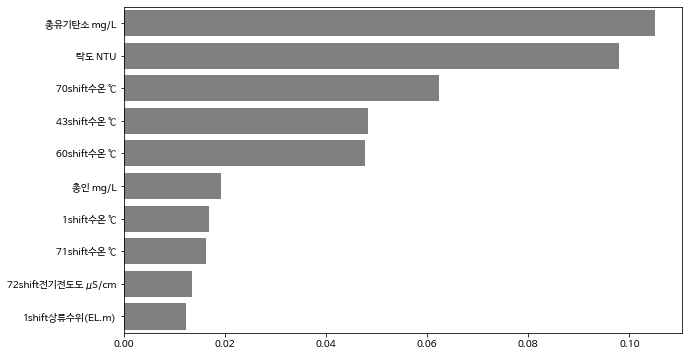

In [73]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [74]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

score : 0.9782615243534266


In [75]:
feature_series[:10]

총유기탄소 mg/L            0.104963
탁도 NTU                0.097905
70shift수온 ℃           0.062031
60shift수온 ℃           0.047629
43shift수온 ℃           0.047465
총인 mg/L               0.019206
1shift수온 ℃            0.016440
71shift수온 ℃           0.016337
72shift전기전도도 μS/cm    0.013885
1shift상류수위(EL.m)      0.012490
dtype: float64